In [1]:
%load_ext autoreload
%autoreload 2

In [87]:
import os
import numpy as np
import json
import cv2

import torch
import torch.nn.functional as F
from torchvision.utils import save_image
import networkx as nx
from matplotlib import pyplot as plt
import matplotlib.patches as patches
from PIL import Image, ImageDraw
import webcolors

from minimal.imaging import draw_plan
from minimal.layout import LayoutGraph
from minimal.gen import generate_plan

%matplotlib inline

In [88]:
g = LayoutGraph([4, 2, 2, 3, 1, 0, 16, 16, 16, 16, 16, 14], [(0, 5), (0, 7), (1, 5), (1, 6), (2, 5), (2, 8), (3, 5), (3, 9), (4, 5), (4, 10), (5, 6), (5, 7), (5, 8), (5, 9), (5, 10), (5, 11)])

In [120]:
masks = generate_plan(g, num_iters=25)

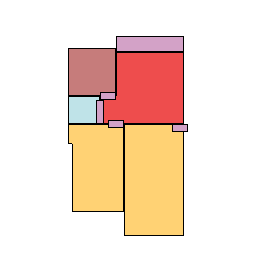

In [121]:
draw_plan(masks, g.nodes)